# ETCCDI Precipitation Indices (NEX‑GDDP via Intake → xarray)

## Model, Date, and Period Selection
Set the selections below. This follows the **same pattern and variable names** used in `Plot_NEX-GDDP.ipynb`.

In [1]:

# --- User selections (same naming as Plot_NEX-GDDP.ipynb) ---
SELECTED_MODEL    = "EC-Earth3"
SELECTED_VARIABLE = "pr"
SELECTED_SCENARIO = "historical"  # e.g., "ssp245", "ssp370", ...

START_DATE = "2001-01-01"
END_DATE   = "2002-12-31"

# Period choices: "Annual","MAM","JJA","SON","DJF"
PERIOD = "Annual"

# NEX-GDDP 'pr' is typically kg m-2 s-1 -> convert to mm/day if True
CONVERT_TO_MM_PER_DAY = True


## Intake → xarray loading 
This cell loads `pr` between your start/end dates.

In [2]:

import warnings; warnings.filterwarnings("ignore")
import intake, xarray as xr, numpy as np

# Same catalog used in Plot_NEX-GDDP.ipynb
CATALOG_URL = "https://raw.githubusercontent.com/aashishpanta0/cmip6-intake-idx/main/cmip6_catalog.yml"
cat = intake.open_catalog(CATALOG_URL)
factory = cat.nex_gddp_cmip6

def _to_list(obj):
    if obj is None: return []
    if isinstance(obj, (list, tuple)): return list(obj)
    if hasattr(obj, "tolist"): 
        try: return obj.tolist()
        except Exception: pass
    return [str(obj)]

MODELS    = _to_list(factory.list_models())
VARIABLES = _to_list(factory.list_variables())
SCENARIOS = _to_list(factory.list_scenarios())

print("Available variables:", VARIABLES)
print("Using:")
print(" Model   :", SELECTED_MODEL)
print(" Variable:", SELECTED_VARIABLE)
print(" Scenario:", SELECTED_SCENARIO)
print(" Period  :", START_DATE, "to", END_DATE)

assert SELECTED_VARIABLE in VARIABLES, f"Variable '{SELECTED_VARIABLE}' not in {VARIABLES}"
assert SELECTED_MODEL in MODELS, f"Model '{SELECTED_MODEL}' not found. First 10: {MODELS[:10]}"
assert SELECTED_SCENARIO in SCENARIOS, f"Scenario '{SELECTED_SCENARIO}' not found. Available: {SCENARIOS}"

# Load the dataset exactly via the factory (mirrors Plot_NEX-GDDP usage)
src = factory(model=SELECTED_MODEL,
              variable=SELECTED_VARIABLE,
              scenario=SELECTED_SCENARIO,
              start_date=START_DATE,
              end_date=END_DATE)

# Some intake drivers expose different read methods; prefer to_dask
try:
    ds = src.to_dask()
except Exception:
    try:
        ds = src.read()
    except Exception:
        ds = src.to_xarray()

# assert SELECTED_VARIABLE in ds, f"Expected '{SELECTED_VARIABLE}' in dataset variables"
da = ds #[SELECTED_VARIABLE]

# Safety: time subset and unit conversion
if "time" in da.dims:
    da = da.sel(time=slice(START_DATE, END_DATE))

if CONVERT_TO_MM_PER_DAY:
    units = str(da.attrs.get("units","")).lower()
    if ("kg" in units and "s-1" in units) or ("kg m-2 s-1" in units) or ("kg m**-2 s**-1" in units):
        da = da * 86400.0
        da.attrs["units"] = "mm/day"
    else:
        # Heuristic: if magnitudes are small, assume kg m-2 s-1
        sample = np.nanmedian(np.asarray(da.isel(time=slice(0, min(30, da.sizes.get("time",30))))))
        if sample < 5.0:
            da = da * 86400.0
            da.attrs["units"] = "mm/day"

print("Loaded:", SELECTED_MODEL, SELECTED_SCENARIO, f"{str(da.time.values[0])[:10]} → {str(da.time.values[-1])[:10]}",
      "| shape:", tuple(da.shape), "| units:", da.attrs.get("units"))


Available variables: ['hurs', 'huss', 'pr', 'rlds', 'rsds', 'sfcWind', 'tas', 'tasmax', 'tasmin']
Using:
 Model   : EC-Earth3
 Variable: pr
 Scenario: historical
 Period  : 2001-01-01 to 2002-12-31
Loaded: EC-Earth3 historical 2001-01-01 → 2002-12-31 | shape: (730, 600, 1440) | units: mm/day


## Period subsetting (Annual/MAM/JJA/SON/DJF)
For DJF, December is assigned to the **following** year so Dec–Jan–Feb are grouped correctly.

In [3]:

import numpy as np

def subset_period(da, period):
    if period == "Annual":
        return da
    months = {"MAM":[3,4,5], "JJA":[6,7,8], "SON":[9,10,11], "DJF":[12,1,2]}
    if period != "DJF":
        return da.sel(time=da["time"].dt.month.isin(months[period]))
    # DJF: shift December to next season-year
    t = da["time"].to_index()
    years = t.year.copy()
    years = np.where(t.month==12, years+1, years)
    sel = (t.month==12) | (t.month<=2)
    return da.sel(time=sel).assign_coords(season_year=("time", years))

da_period = subset_period(da, PERIOD)


## Compute ETCCDI indices (using your `ETCCDI_pr_indices.py`) and build climatologies
Each function is applied to the **period data of each year**, and the outputs are **averaged over years** to form climatology maps.

In [4]:

import numpy as np, numpy.ma as ma, importlib.util

# Import your index implementations
mod_path = "./ETCCDI_pr_indices.py"
spec = importlib.util.spec_from_file_location("ETCCDI_pr_indices", mod_path)
ET = importlib.util.module_from_spec(spec)
spec.loader.exec_module(ET)

arr  = np.asarray(da_period)
mask = np.isnan(arr)
marr = ma.masked_array(arr, mask=mask)

# Select year or DJF season-year
if PERIOD == "DJF":
    years = np.asarray(da_period["season_year"].values)
else:
    years = da_period["time"].dt.year.values

uniq_years = np.unique(years)
print(f"Years included for period '{PERIOD}':", uniq_years[:10], "..." if len(uniq_years)>10 else "")

def stack_mean_over_years(func):
    outs = []
    for y in uniq_years:
        sel = marr[years == y, ...]  # (time_in_period, ny, nx)
        if sel.shape[0] == 0:
            continue
        outs.append(func(sel))
    if len(outs) == 0:
        raise RuntimeError("No data for the selected window/period.")
    return ma.stack(outs, axis=0).mean(axis=0)

RX1 = stack_mean_over_years(ET.rx1day)
RX5 = stack_mean_over_years(ET.rx5day)
R10 = stack_mean_over_years(ET.r10mm)
R20 = stack_mean_over_years(ET.r20mm)
CDD = stack_mean_over_years(ET.cdd)
CWD = stack_mean_over_years(ET.cwd)


Years included for period 'Annual': [2001 2002] 


## Plot climatologies

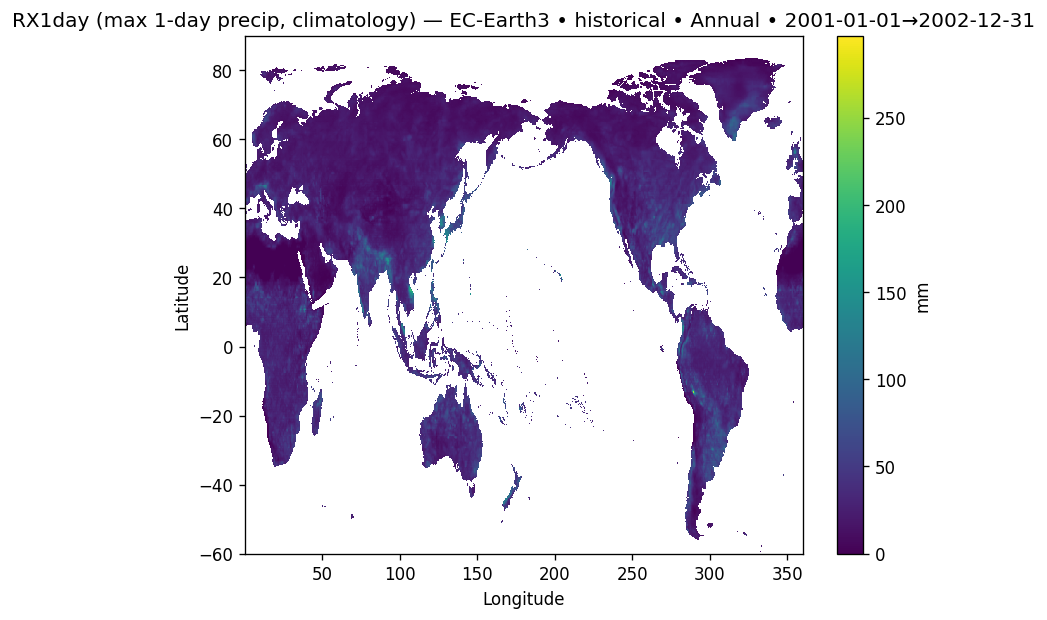

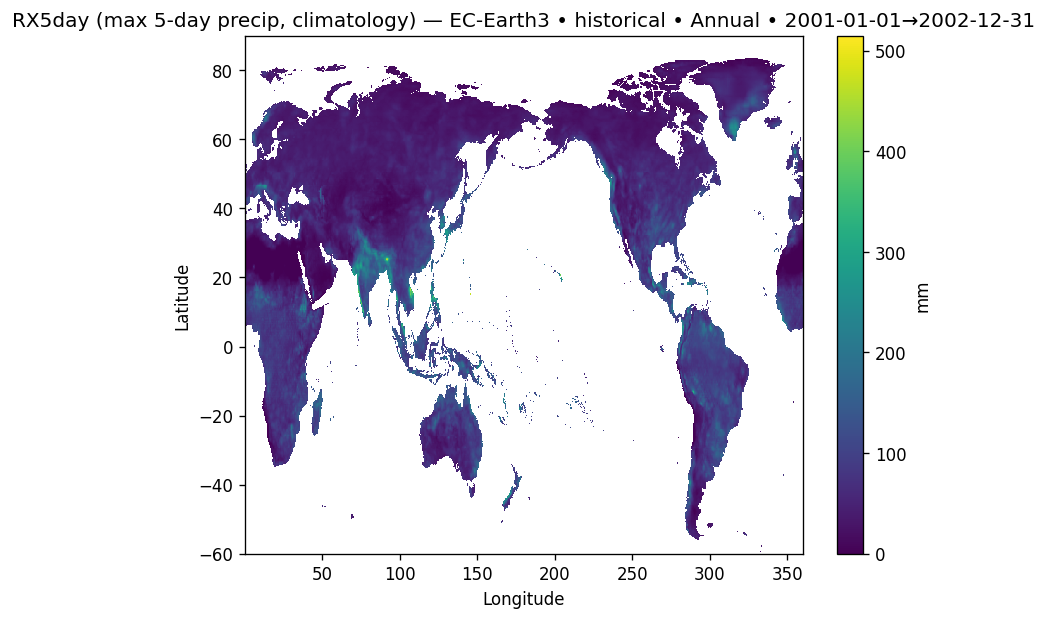

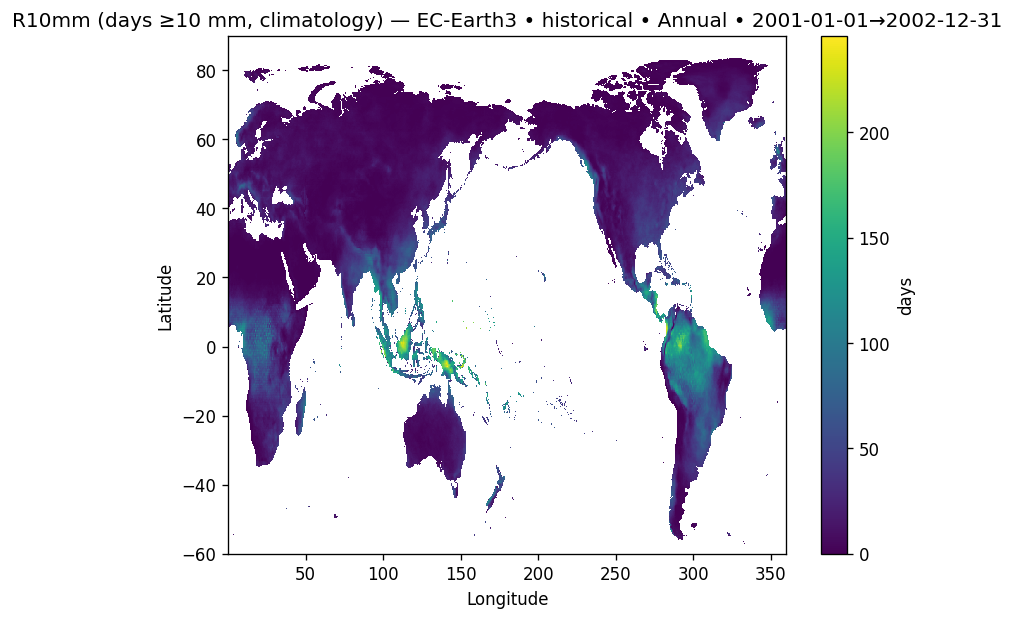

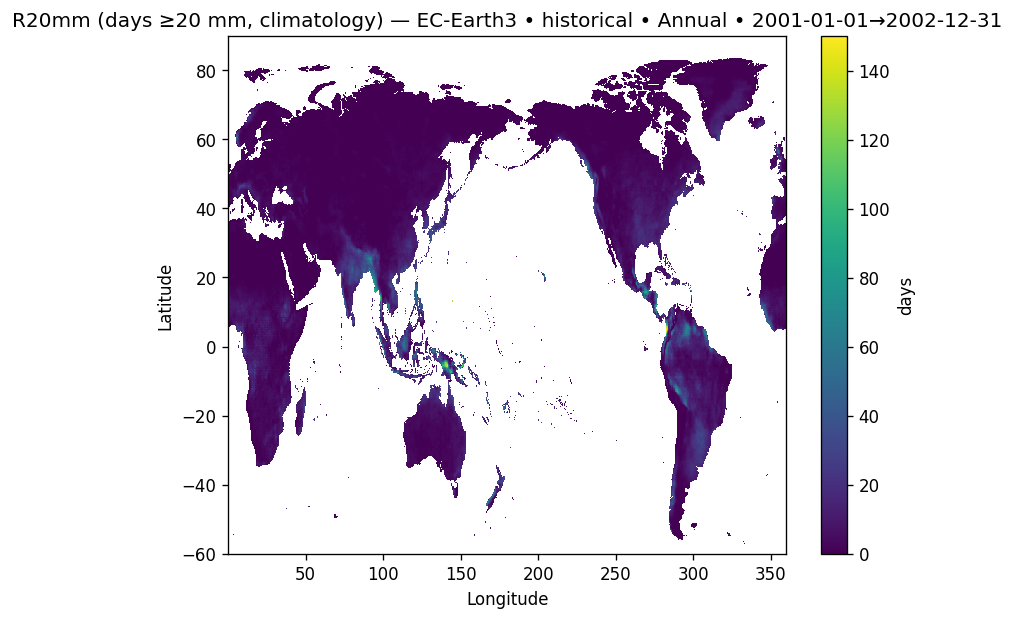

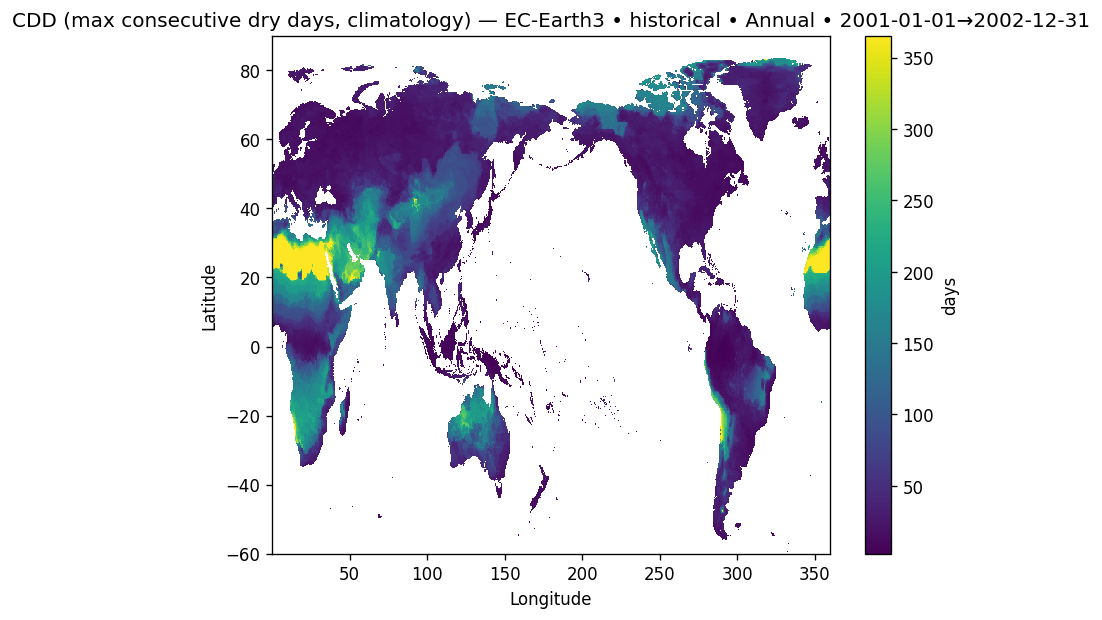

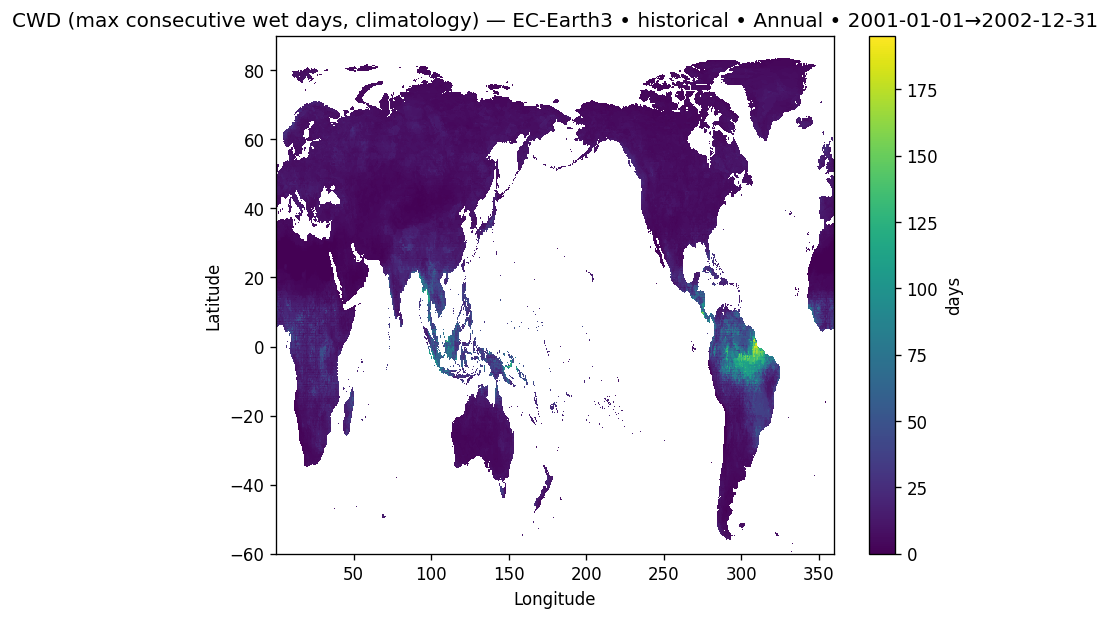

In [5]:

import matplotlib.pyplot as plt
import numpy as np

# Build lon/lat 2D
lat_name = [n for n in da.coords if n.lower() in ("lat","latitude","y")][0]
lon_name = [n for n in da.coords if n.lower() in ("lon","longitude","x")][0]
lat = da[lat_name].values
lon = da[lon_name].values
if lat.ndim == 1 and lon.ndim == 1:
    LON2D, LAT2D = np.meshgrid(lon, lat)
else:
    LAT2D, LON2D = lat, lon

def plot_field(field, title, cbar_label):
    plt.figure(figsize=(7.5,5.6), dpi=120)
    im = plt.pcolormesh(LON2D, LAT2D, field, shading="auto")
    plt.colorbar(im, label=cbar_label)
    plt.title(title)
    plt.xlabel("Longitude"); plt.ylabel("Latitude")
    plt.show()

suffix = f"{SELECTED_MODEL} • {SELECTED_SCENARIO} • {PERIOD} • {START_DATE}→{END_DATE}"
plot_field(RX1, f"RX1day (max 1-day precip, climatology) — {suffix}", "mm")
plot_field(RX5, f"RX5day (max 5-day precip, climatology) — {suffix}", "mm")
plot_field(R10, f"R10mm (days ≥10 mm, climatology) — {suffix}", "days")
plot_field(R20, f"R20mm (days ≥20 mm, climatology) — {suffix}", "days")
plot_field(CDD, f"CDD (max consecutive dry days, climatology) — {suffix}", "days")
plot_field(CWD, f"CWD (max consecutive wet days, climatology) — {suffix}", "days")
